Direct identifier:
 - phone number -> salt + hash (becomes the ID for the pseudonymized dataset)

Quasi-identifiers:
 - postcode -> only keep the outcode (the first half of the postcode)
 - area -> not sure yet if we keep it or not because it brings the same information as the outcode
 - dob -> only keep the year of birth (the only info needed is the age)
 - gender -> keep it for now (maybe useful to use case 1) and see if we delete it later
 - ethnic group -> we'll have to check later that it doesn't affect the k-anonymity
 - marital status -> keep it for now and see if we need to delete it to get the k-anonymity we want
 - qualifications -> keep it (useful for pay inequity)
 - occupation -> keep it (useful for pay inequity and it's not too precise)
 - home ownership -> nothing to change (it's just 0 or 1)

Sensitive information:
 - income -> keep it as is (maybe generalize it later to ranges if needed)
 - distance to work -> generalize it to ranges and separate 0


# 1) Loading the data

We first load the data and import modules.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# file_path = '/content/drive/MyDrive/Colab Notebooks/PE - coursework/dataset_updated.csv'
file_path = 'dataset.csv'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import hashlib
import random
import math
from datetime import datetime
import matplotlib.pyplot as plt
# !pip install uk_postcodes_parsing #Needed on colab
from uk_postcodes_parsing import ukpostcode
%matplotlib inline

# mapping from area codes to regions
area_code_to_region = {'AB': 'Scotland', 'AL': 'East of England', 'B': 'West Midlands', 'BA': 'South West', 'BB': 'North West', 'BD': 'North West', 'BH': 'South West', 'BL': 'North West', 'BN': 'South East', 'BR': 'Greater London', 'BS': 'South West', 'BT': 'Northern Ireland', 'CA': 'North West', 'CB': 'East of England', 'CF': 'Wales', 'CH': 'North West', 'CM': 'East of England', 'CO': 'East of England', 'CR': 'Greater London', 'CT': 'South East', 'CV': 'West Midlands', 'CW': 'North West', 'DA': 'Greater London', 'DD': 'Scotland', 'DE': 'East Midlands', 'DG': 'Scotland', 'DH': 'North East', 'DL': 'North East', 'DN': 'East Midlands', 'DT': 'South West', 'DY': 'West Midlands', 'E': 'Greater London', 'EC': 'Greater London', 'EH': 'Scotland', 'EN': 'Greater London', 'EX': 'South West', 'FK': 'Scotland', 'FY': 'North West', 'G': 'Scotland', 'GL': 'South West', 'GU': 'South East', 'GY': 'Channel Islands', 'HA': 'Greater London', 'HD': 'North West', 'HG': 'North East', 'HP': 'East of England', 'HR': 'West Midlands', 'HS': 'Scotland', 'HU': 'North East', 'HX': 'North West', 'IG': 'Greater London', 'IM': 'Isle of Man', 'IP': 'East of England', 'IV': 'Scotland', 'JE': 'Channel Islands', 'KA': 'Scotland', 'KT': 'Greater London', 'KW': 'Scotland', 'KY': 'Scotland', 'L': 'North West', 'LA': 'North West', 'LD': 'Wales', 'LE': 'East Midlands', 'LL': 'Wales', 'LN': 'East Midlands', 'LS': 'North East', 'LU': 'East of England', 'M': 'North West', 'ME': 'South East', 'MK': 'South East', 'ML': 'Scotland', 'N': 'Greater London', 'NE': 'North East', 'NG': 'East Midlands', 'NN': 'West Midlands', 'NP': 'Wales', 'NR': 'East of England', 'NW': 'Greater London', 'OL': 'North West', 'OX': 'South East', 'PA': 'Scotland', 'PE': 'East England', 'PH': 'Scotland', 'PL': 'South West', 'PO': 'South East', 'PR': 'North West', 'QC': 'Non-geographic', 'RG': 'South East', 'RH': 'South East', 'RM': 'Greater London', 'S': 'East Midlands', 'SA': 'Wales', 'SE': 'Greater London', 'SG': 'East of England', 'SK': 'North West', 'SL': 'South East', 'SM': 'Greater London', 'SN': 'South West', 'SO': 'South East', 'SP': 'South West', 'SR': 'North East', 'SS': 'East of England', 'ST': 'West Midlands', 'SW': 'Greater London', 'SY': 'Wales', 'TA': 'South West', 'TD': 'Scotland', 'TF': 'West Midlands', 'TN': 'South East', 'TQ': 'South West', 'TR': 'South West', 'TS': 'North East', 'TW': 'Greater London', 'UB': 'Greater London', 'W': 'Greater London', 'WA': 'North West', 'WC': 'Greater London', 'WD': 'Greater London', 'WF': 'North East', 'WN': 'North West', 'WR': 'West Midlands', 'WS': 'West Midlands', 'WV': 'West Midlands', 'YO': 'North East', 'ZE': 'Scotland'}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.3 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv(file_path)
df.head()

,area,postcode,dob,gender,ethnic_group,phone_number,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km
0,Nottingham,NG9 5SS,1989-04-18,Female,"White: English, Welsh, Scottish, Northern Iris...",447546351661,married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169
1,Shropshire,SY6 0LT,1989-04-19,Female,"White: English, Welsh, Scottish, Northern Iris...",447979438189,divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000
2,Wakefield,LS26 0UG,1982-11-04,Female,White: Roma,447950956938,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012
3,Tunbridge Wells,TN5 2QQ,2007-12-10,Female,"White: English, Welsh, Scottish, Northern Iris...",447970878589,never_married,Level 1 (School),No occupation,4469,0,0.000000
4,Walsall,WS3 1GO,1950-01-15,Male,"White: English, Welsh, Scottish, Northern Iris...",447659064207,married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231


# 2) Identifier anonymisation

The first stage is to protect the unique identifier of each row. In this case, it is the phone number of the person. To do this, we generate a salted hash. We generate a random seeded salt (256 characters so it cannot be brute forced). We then salt and hash each phone number and make this into the index column of the dataframe.

In [ ]:
# Salt and hash the id
random.seed(345)

ALPHABET = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
salt = ''
for i in range(0, 256):
    salt += random.choice(ALPHABET)

def hash(phone_number):
    salted_phone_number = str(phone_number) + salt
    return hashlib.sha256(salted_phone_number.encode()).hexdigest()

df['hashed_phone_number'] = df['phone_number'].map(hash)

df.drop('phone_number', axis=1, inplace=True)
df.set_index('hashed_phone_number', inplace=True)
df.index.name = None

df.head()


,area,postcode,dob,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Nottingham,NG9 5SS,1989-04-18,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Shropshire,SY6 0LT,1989-04-19,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000
acce63e0f7f8741779d2f8b905a7b383c02d1a23a03e292c1ff9451cf9d94250,Wakefield,LS26 0UG,1982-11-04,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Tunbridge Wells,TN5 2QQ,2007-12-10,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Walsall,WS3 1GO,1950-01-15,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231


# 3) k-anonymity

The second stage is to see how to adapt our dataset to get the k-anonymity we want (at least 5-anonymity).

In [ ]:
# Function to analyse the k-anonymity on a certain set of columns
## This function prints a list of tuples (x, y), where each tuple (x, y) means
## that there are y equivalence classes of size x. It prints only tuples where
## y is non-zero and only up to x = 100.
## It also prints a histogram of the number of equivalence classes of each size
## (not limited to size 100).
def size_equivalence_classes_all(dataset, data_to_consider):
    grouped = dataset.groupby(data_to_consider)
    nb = [len(g[1]) for g in grouped]
    a = plt.hist(nb, bins=np.arange(1, max(nb)+2, 1), align='left', width=.9)
    print([(i+1, int(a[0][i])) for i in range(min(101, len(a[0]))) if a[0][i] > 0])
    plt.xlabel("Size of Equivalence Classes")
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")
    #plt.xticks(range(1000, max(nb)+1, 1000))
    #plt.yticks(range(20000, 100001, 20000))
    plt.show()

# Function to analyse the k-anonymity on a certain set of columns
## This function prints a list of tuples (x, y), where each tuple (x, y) means
## that there are y equivalence classes of size x. It prints only tuples where
## y is non-zero and only up to x = 10.
## It also prints a histogram of the number of equivalence classes of each size
## up to size 10.
def size_equivalence_classes(dataset, data_to_consider):
    grouped = dataset.groupby(data_to_consider)
    nb = [len(g[1]) for g in grouped]
    a = plt.hist(nb, bins=np.arange(1, 11, 1), align='left', width=.9)
    print([(i+1, int(a[0][i])) for i in range(min(11, len(a[0]))) if a[0][i] > 0])
    plt.xlabel("Size of Equivalence Classes")
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")
    plt.xticks(range(1, 11))
    plt.yticks(range(20000, 100001, 20000))
    plt.show()

# Function to analyse the k-anonymity on a certain set of columns
## This function prints a list of tuples (x, y), where each tuple (x, y) means
## that there are y equivalence classes of size x. It prints only tuples where
## y is non-zero and only up to x = 10.
## It also prints a histogram of the number of equivalence classes of each size
## up to size 10.
def size_equivalence_classes_small(dataset, data_to_consider):
    grouped = dataset.groupby(data_to_consider)
    nb = [len(g[1]) for g in grouped]
    a = plt.hist(nb, bins=np.arange(1, 11, 1), align='left', width=.9)
    print([(i+1, int(a[0][i])) for i in range(min(11, len(a[0]))) if a[0][i] > 0])
    plt.xlabel("Size of Equivalence Classes")
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")
    plt.xticks(range(1, 11))
    plt.yticks(range(2000, 10001, 2000))
    plt.show()

Before testing the k-anonymity, the first thing to do is to replace the date-of-birth by the age. Otherwise, we have a lot of size 1 equivalence classes because of the date-of-birth. We can do this because use case 3 only needs ages and not exact days of birth.

In [ ]:
# Function to compute the age from the date of birth
def calculate_age(dob):
    birth_year = int(dob.split('-')[0])
    current_year = 2024
    return current_year - birth_year

# Replace the dob by the age in the DataFrame
df['age'] = df['dob'].map(calculate_age)
df.drop('dob', axis=1, inplace=True)
df.head()

,area,postcode,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Nottingham,NG9 5SS,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Shropshire,SY6 0LT,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35
acce63e0f7f8741779d2f8b905a7b383c02d1a23a03e292c1ff9451cf9d94250,Wakefield,LS26 0UG,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Tunbridge Wells,TN5 2QQ,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Walsall,WS3 1GO,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74


When trying to improve k-anonymity, we will not consider the marital status. This is because we judged that this column does not provide useful information. So we will not drop it for now, we will try to improve our k-anonymity without considering it and once we have the k-anonymity we want, we will only keep the marital status column if it does not affect it.

## 3.1) Area and postcode

We'll first try to improve our k-anonymity by considering the area and postcode columns.

[(1, 100000)]


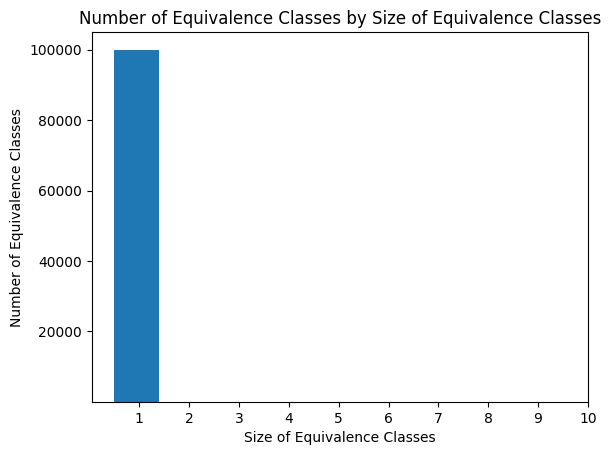

In [ ]:
# Check the equivalence classes' sizes on all columns except for income and distance to work (because they are sensitive information)
size_equivalence_classes(df, ["postcode", "area", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

We only have size 1 equivalence classes right now, which is really bad, but normal since we have modified almost nothing yet. We can still check the impact of the area and postcode on the k-anonymity.

[(1, 20244), (2, 4387), (3, 2006), (4, 1195), (5, 905), (6, 654), (7, 504), (8, 363), (9, 563)]


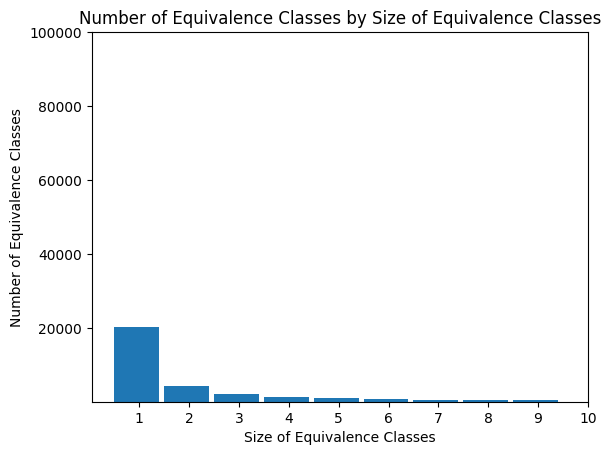

In [ ]:
# Checking the size of the equivalence classes without considering the area and postcode columns
size_equivalence_classes(df, ["age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

This is much better as we go from 100 000 size-1 equivalence classes to 27 413 size-1 equivalence classes. So we can see that the area and postcode have a huge impact on the size of our equivalence classes.

[(4, 1), (17, 1), (64, 1), (97, 2), (98, 1)]


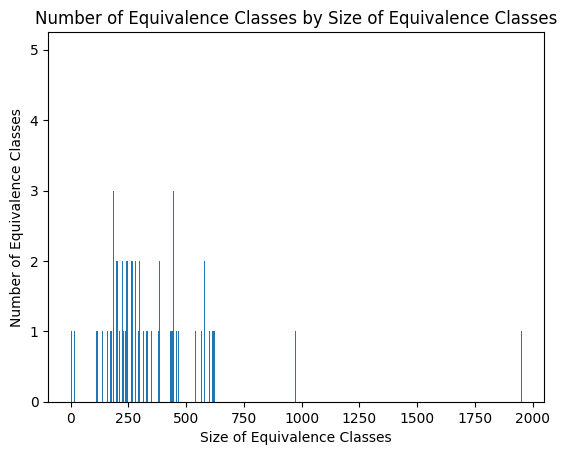

[(1, 99040), (2, 477), (3, 2)]


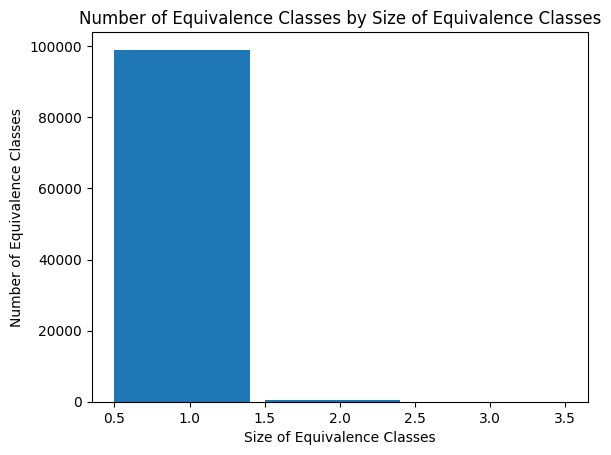

In [ ]:
# Check what the equivalence classes look like for just the area and postcodes to visualize better what it looks like
size_equivalence_classes_all(df, ["area"])
size_equivalence_classes_all(df, ["postcode"])

We can see two issues here: the postcodes are much too precise and there is one equivalence class of size 4 and one of size 17 for the area, which is really little. This is a privacy issue as well because we don't want to release too accurate information on where people live. Since use case 2 only needs regions, we could simply generalize the postcodes and areas to regions, but we will first try keep something more precise and only generalize to regions if our k-anonymity is still really bad. To do this, we will try non-perturbative methods: suppression and generalization.

We first remove the two equivalence classes of sizes 4 and 17 to see the impact this has.

In [ ]:
# This function removes the equivalence classes of size k from the dataset
def remove_area_equivalence_classes(df, k):
  values = df.groupby("area").count()['postcode']
  drop_records_area = (values[values == k]).index[0]
  print("The area dropped is: ", drop_records_area)
  to_drop_rows = df[df['area'] == drop_records_area]
  new_df = df.drop(list(to_drop_rows.index), inplace=False)
  return new_df

# Remove the two equivalence classes of sizes 4 and 17
smaller_df = remove_area_equivalence_classes(df, 4)
smaller_df = remove_area_equivalence_classes(smaller_df, 17)

The area dropped is:  Isles of Scilly
The area dropped is:  City of London


[(64, 1), (97, 2), (98, 1)]


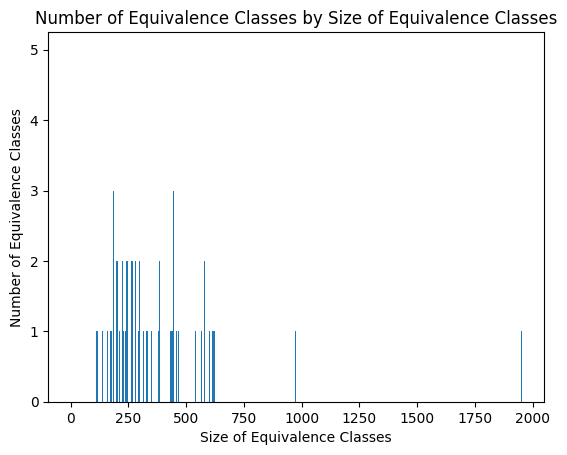

[(1, 99019), (2, 477), (3, 2)]


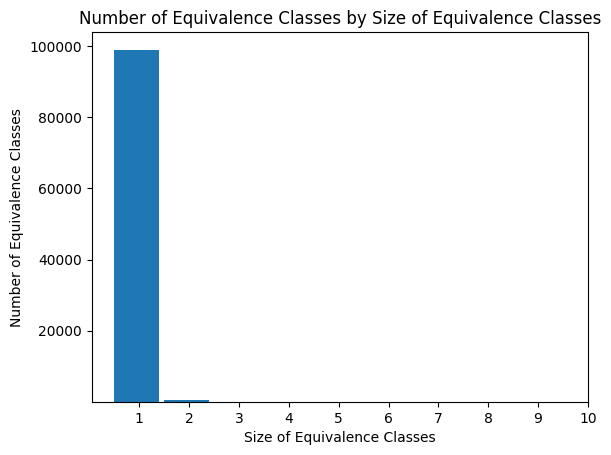

[(1, 99979)]


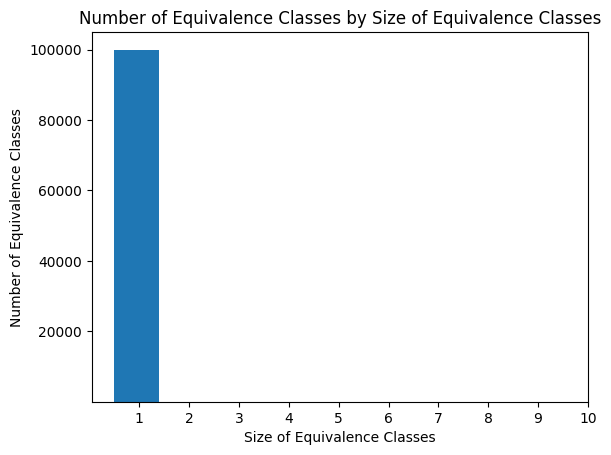

In [ ]:
# Analyze the impact this has on the sizes of the equivalence classes
size_equivalence_classes_all(smaller_df, ["area"])
size_equivalence_classes(smaller_df, ["postcode"])
size_equivalence_classes(smaller_df, ["area", "postcode", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

As expected, the postcode is still much too precise, so we will now try to generalize postcodes to outcodes.

In [ ]:
# This function returns the outcode corresponding to the postcode
def postcode_to_outcode(postcode):
  return postcode.split()[0]

# Change the postcodes to outcodes in the DataFrame
outcodes = [postcode_to_outcode(x) for x in smaller_df.postcode]
smaller_df["postcode"] = outcodes
smaller_df.rename(columns = {"postcode": "outcode"}, inplace=True)
smaller_df.head()

,area,outcode,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Nottingham,NG9,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Shropshire,SY6,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35
acce63e0f7f8741779d2f8b905a7b383c02d1a23a03e292c1ff9451cf9d94250,Wakefield,LS26,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Tunbridge Wells,TN5,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Walsall,WS3,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74


[(2, 2), (3, 2), (4, 10), (5, 7), (6, 9), (7, 19), (8, 27), (9, 22), (10, 28), (11, 31), (12, 35), (13, 24), (14, 33), (15, 38), (16, 27), (17, 31), (18, 41), (19, 27), (20, 37), (21, 37), (22, 22), (23, 33), (24, 32), (25, 42), (26, 38), (27, 28), (28, 38), (29, 47), (30, 50), (31, 33), (32, 29), (33, 53), (34, 38), (35, 26), (36, 25), (37, 40), (38, 44), (39, 28), (40, 28), (41, 29), (42, 21), (43, 36), (44, 25), (45, 26), (46, 25), (47, 21), (48, 26), (49, 24), (50, 20), (51, 22), (52, 18), (53, 18), (54, 22), (55, 21), (56, 20), (57, 20), (58, 13), (59, 19), (60, 18), (61, 11), (62, 20), (63, 17), (64, 20), (65, 16), (66, 20), (67, 22), (68, 11), (69, 8), (70, 20), (71, 19), (72, 18), (73, 15), (74, 20), (75, 10), (76, 14), (77, 15), (78, 10), (79, 10), (80, 16), (81, 7), (82, 8), (83, 12), (84, 8), (85, 9), (86, 6), (87, 11), (88, 6), (89, 6), (90, 3), (91, 4), (92, 6), (93, 2), (94, 6), (95, 7), (96, 5), (97, 8), (98, 5), (99, 4), (100, 9), (101, 5)]


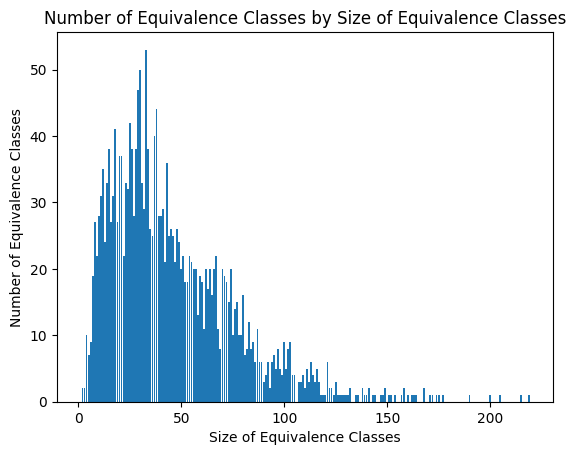

[(1, 99229), (2, 366), (3, 6)]


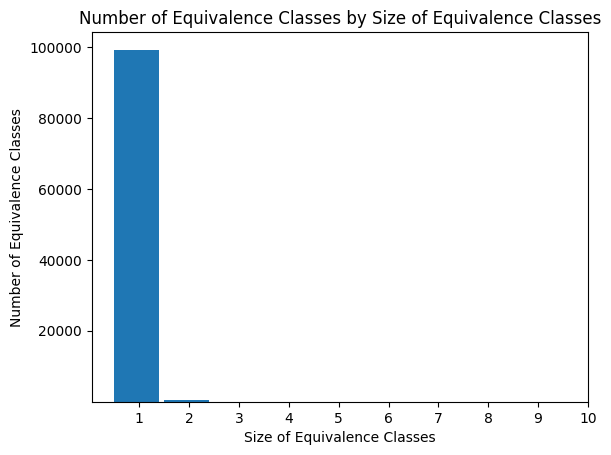

In [ ]:
# Plot the equivalence classes again
size_equivalence_classes_all(smaller_df, ["outcode"])
size_equivalence_classes(smaller_df, ["area", "outcode", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

These numbers are still not good enough since we have 99 489 size-1 equivalence classes. The next step in generalization is to generalize the "area" and "outcodes" to just "area".

[(1, 93202), (2, 2682), (3, 297), (4, 79), (5, 18), (6, 6), (7, 3), (8, 2), (9, 2)]


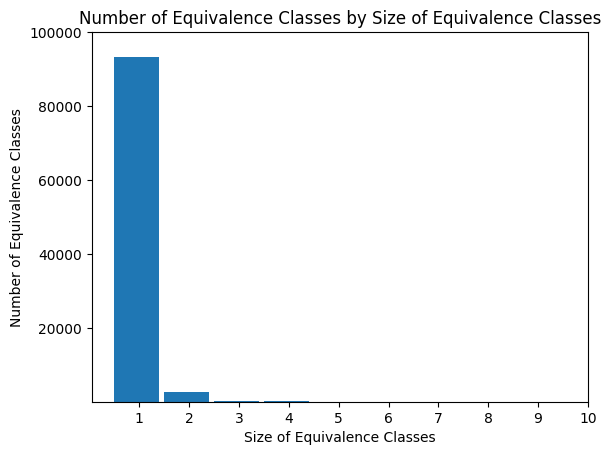

,area,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Nottingham,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Shropshire,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35
acce63e0f7f8741779d2f8b905a7b383c02d1a23a03e292c1ff9451cf9d94250,Wakefield,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Tunbridge Wells,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Walsall,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74


In [ ]:
# Drop the outcodes from the DataFrame and check the equivalence classes again
smaller_df.drop("outcode", axis=1, inplace=True)
size_equivalence_classes(smaller_df, ["area", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])
smaller_df.head()

This is still not as good as we would want it to be. So we will now try to generalize further to replace the areas by their corresponding regions. To do this, we need to get back to the version with the postcodes. So the records from the sizes 4 and 17 for the area are back in the DataFrame, which is best since they might not be an issue anymore as we are generalizing to regions.

In [ ]:
# Get a mapping to map the areas to the regions
def get_region(postcode_area):
  return area_code_to_region[postcode_area]

# Define a function to get the area code from the postcodes
def get_postcode_info(postcode):
  postcode_info = ukpostcode.parse(postcode)
  return postcode_info.area

# Replace the postcode column by a region column and drop the area column
df['area_code'] = df['postcode'].map(get_postcode_info)
df['region'] = df['area_code'].map(get_region)
df.drop(['postcode', 'area_code', 'area'], axis=1, inplace=True)
df.head()

,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age,region
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35,East Midlands
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35,Wales
acce63e0f7f8741779d2f8b905a7b383c02d1a23a03e292c1ff9451cf9d94250,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42,North East
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17,South East
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74,West Midlands


[(1, 50322), (2, 9063), (3, 3337), (4, 1428), (5, 674), (6, 419), (7, 212), (8, 143), (9, 171)]


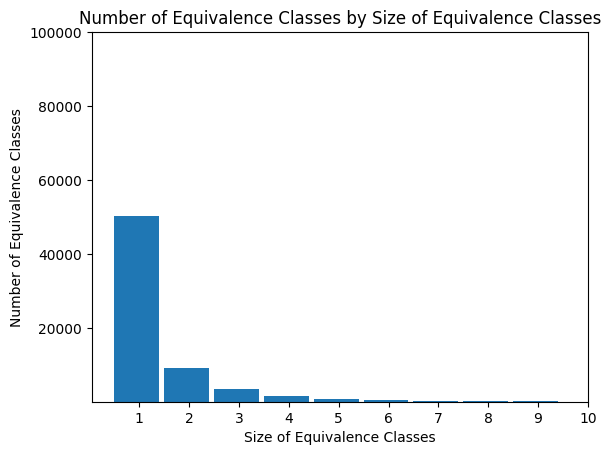

,gender
region,
East England,1743
East Midlands,10043
East of England,7929
Greater London,18090
North East,8945
North West,15451
Scotland,96
South East,13986
South West,8167


In [ ]:
# We can check the equivalence classes again
size_equivalence_classes(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

# We can check how many people there are in each region as well, to notice any disparities
grouped_by_region = df.groupby(["region"]).count()["gender"]
grouped_by_region

We finally see a real improvement as the number of size-1 equivalence classes drops to 50 322. However, we can notice disparities in the table since there are only 96 people from Scotland, which is really little compared to other regions. We might want to use suppression to remove these 96 records, but we will wait until after generalizing the other quasi-identifiers to see whether deleting these records has a beneficial enough impact.

## 3.2) Age

[(1, 50322), (2, 9063), (3, 3337), (4, 1428), (5, 674), (6, 419), (7, 212), (8, 143), (9, 171)]


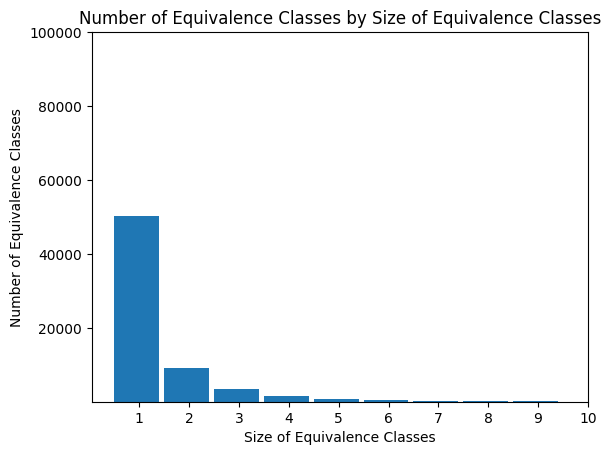

[(1, 7007), (2, 2390), (3, 1163), (4, 687), (5, 433), (6, 307), (7, 203), (8, 166), (9, 248)]


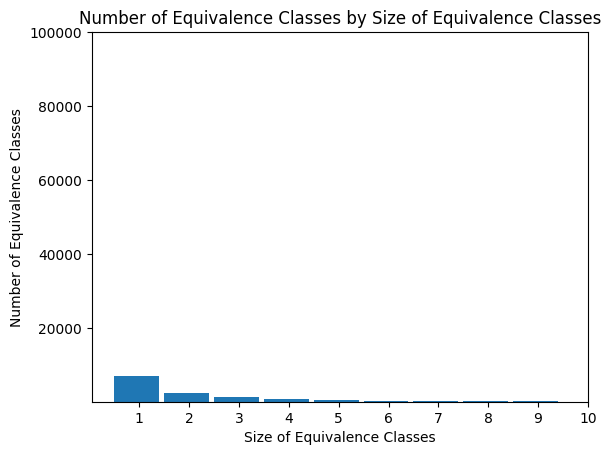

In [ ]:
size_equivalence_classes(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(df, ["region", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

As expected, the age has a non-negligeable impact on the size of the equivalence classes. However, we cannot generalize the age too much, as otherwise, this will impede utility. Since use case 3 compares the distance to work to the age, having small logical age ranges seems reasonable (for instance, since most people over 65 do not work anymore and thus do not have a distance to work, it seems reasonable to group them in a "over 65" range).

[(1, 16508), (2, 3914), (3, 1663), (4, 1036), (5, 690), (6, 505), (7, 385), (8, 336), (9, 465)]


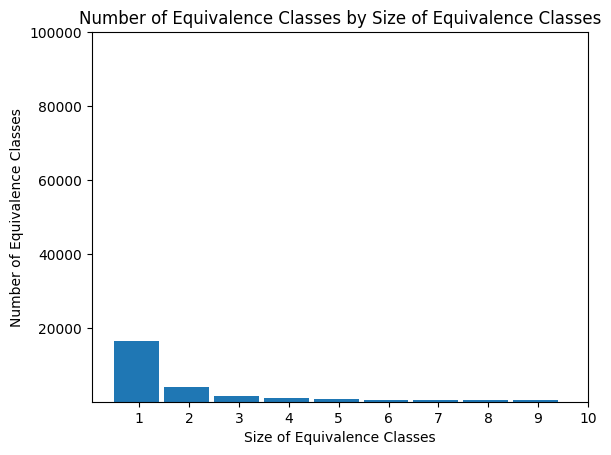

In [ ]:
# This function maps the age to an age range
## The age ranges are: 16-25, 25-40, 40-50, 50-65, over 65
def age_group(age):
    if age >= 65:
        return '>65'
    elif age >= 50:
        return '50-65'
    elif age >= 40:
        return '40-50'
    elif age >= 25:
        return '25-40'
    else:
        return '16-25'

# Change the ages to age ranges and consider the impact on k-anonymity
df['age'] = df['age'].map(age_group)
size_equivalence_classes(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

We were able to reduce the number of size-1 equivalence classes to 16 508, which is really good.

##3.3) Ethnicity

[(1, 16508), (2, 3914), (3, 1663), (4, 1036), (5, 690), (6, 505), (7, 385), (8, 336), (9, 465)]


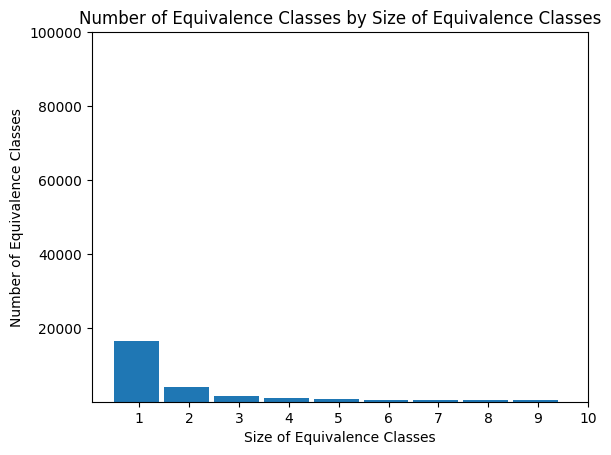

[(1, 2191), (2, 1259), (3, 835), (4, 708), (5, 541), (6, 463), (7, 413), (8, 329), (9, 522)]


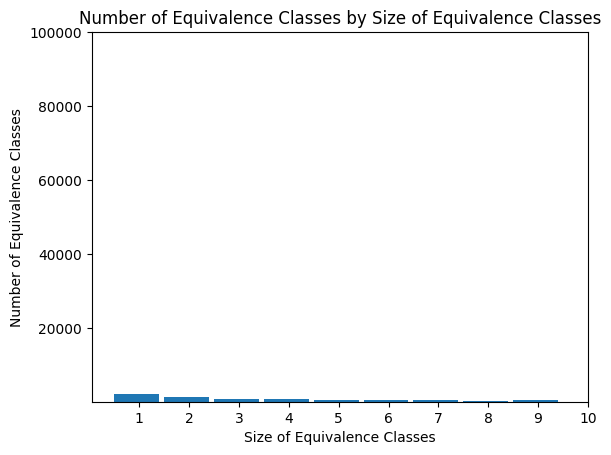

In [ ]:
size_equivalence_classes(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(df, ["region", "age", "gender", "qualifications", "occupation", "home_ownership"])

We can see that the ethnic group information has an important impact on the size of the equivalence classes, so we will now try to generalize it to improve k-anonymity.

[(1, 8721), (2, 3163), (3, 1612), (4, 1091), (5, 756), (6, 542), (7, 444), (8, 352), (9, 531)]


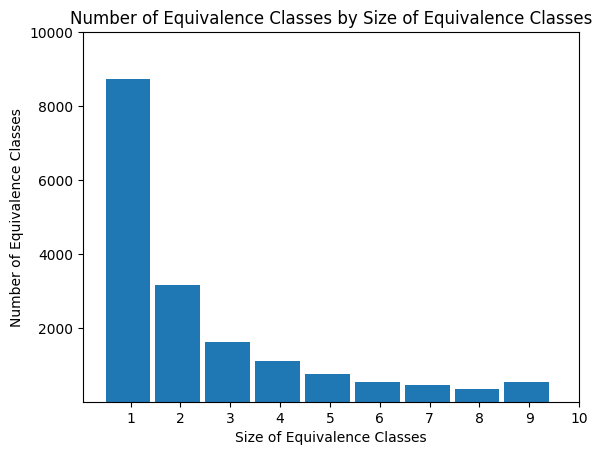

In [ ]:
# This is a dictionary, mapping the original ethnic groups to more "generalised" ethnic groups
map_ethnic_group = {'Asian, Asian British or Asian Welsh: Bangladeshi': "Asian",
 'Asian, Asian British or Asian Welsh: Chinese': "Asian",
 'Asian, Asian British or Asian Welsh: Indian': "Asian",
 'Asian, Asian British or Asian Welsh: Other Asian': "Asian",
 'Asian, Asian British or Asian Welsh: Pakistani': "Asian",
 'Black, Black British, Black Welsh, Caribbean or African: African': "Black",
 'Black, Black British, Black Welsh, Caribbean or African: Caribbean': "Black",
 'Black, Black British, Black Welsh, Caribbean or African: Other Black': "Black",
 'Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups': "Mixed",
 'Mixed or Multiple ethnic groups: White and Asian': "Mixed",
 'Mixed or Multiple ethnic groups: White and Black African': "Mixed",
 'Mixed or Multiple ethnic groups: White and Black Caribbean': "Mixed",
 'Other ethnic group: Any other ethnic group': "Other",
 'Other ethnic group: Arab': "Other",
 'White: English, Welsh, Scottish, Northern Irish or British': "White",
 'White: Gypsy or Irish Traveller': "White",
 'White: Irish': "White",
 'White: Other White': "White",
 'White: Roma': "White"}

# We can now update our data frame and observe the impact on the equivalence classes
df['ethnic_group'] = df['ethnic_group'].map(lambda x: map_ethnic_group[x.rstrip()])
size_equivalence_classes(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

##3.4) Qualifications

In [ ]:
# TO DELETE #
df = ethnicity_df.copy()

In [ ]:
regroup_mapping = {
    'Level 4 (BA+) or above': 'Level 4 (BA+) or above',
    'Level 3 (High school)': 'Level 1-3 (School)',
    'Level 2 (School)': 'Level 1-3 (School)',
    'Level 1 (School)': 'Level 1-3 (School)',
    'Apprenticeship': 'Apprenticeship',
    'Other': 'Other'
}

df['qualifications'] = df['qualifications'].map(regroup_mapping)

#df.head()


[(1, 5859), (2, 2413), (3, 1258), (4, 805), (5, 490), (6, 361), (7, 291), (8, 226), (9, 320)]


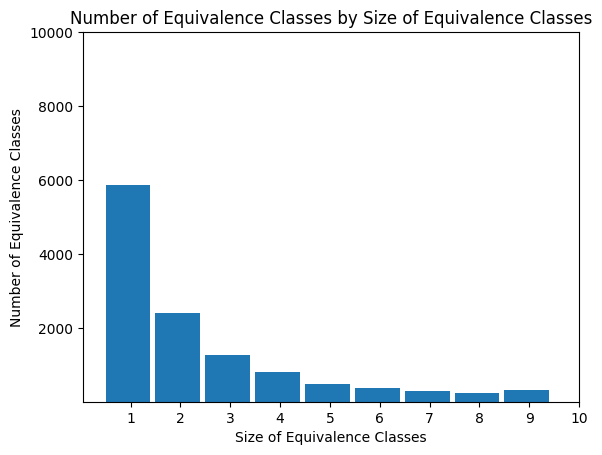

In [ ]:
size_equivalence_classes_small(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

In [ ]:
# TO DELETE #
qualifications_df = df.copy()

##3.5) Occupation

In [ ]:
# TO DELETE #
df = qualifications_df.copy()

In [ ]:
regroup_mapping = {
    '2. Professional occupations': 'Management and Professional Occupations',
    '3. Associate professional and technical occupations': 'Management and Professional Occupations',
    '1. Managers, directors and senior officials': 'Management and Professional Occupations',
    '4. Administrative and secretarial occupations': 'Administrative and Support Occupations',
    '7. Sales and customer service occupations': 'Administrative and Support Occupations',
    '5. Skilled trades occupations': 'Skilled and Technical Occupations',
    '8. Process, plant and machine operatives': 'Skilled and Technical Occupations',
    '6. Caring, leisure and other service occupations': 'Service and Care Occupations',
    '9. Elementary occupations': 'Service and Care Occupations',
    'No occupation': 'Unemployed'
}

df['occupation'] = df['occupation'].map(regroup_mapping)
df.head()

,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age,region
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Female,White,married,Level 4 (BA+) or above,Service and Care Occupations,29445,1,4.593169,25-40,East Midlands
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Female,White,divorced,Level 4 (BA+) or above,Management and Professional Occupations,110432,1,0.000000,25-40,Wales
acce63e0f7f8741779d2f8b905a7b383c02d1a23a03e292c1ff9451cf9d94250,Female,White,never_married,Other,Skilled and Technical Occupations,22891,0,6.285012,40-50,North East
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Female,White,never_married,Level 1-3 (School),Unemployed,4469,0,0.000000,16-25,South East
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Male,White,married,Level 1-3 (School),Administrative and Support Occupations,26406,0,17.225231,>65,West Midlands


[(1, 3306), (2, 1471), (3, 875), (4, 555), (5, 384), (6, 266), (7, 245), (8, 162), (9, 260)]


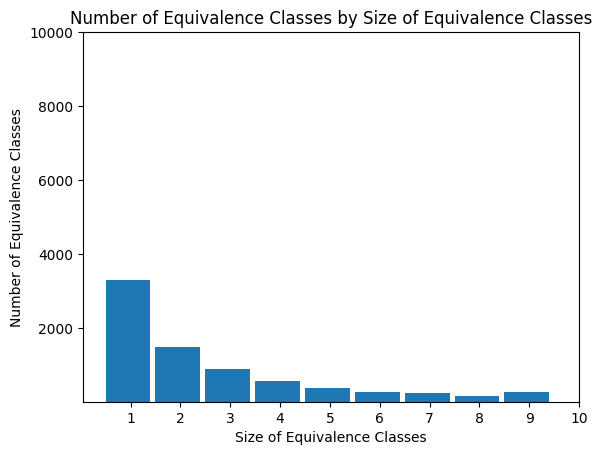

In [ ]:
size_equivalence_classes_small(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])

## 3.6) Suppression

###3.6.1) Marital status
We were considering deleting this anyway as it's not used in a use case, and as it does make significant difference to the equivalnce classes of size 1 we did

[(1, 3306), (2, 1471), (3, 875), (4, 555), (5, 384), (6, 266), (7, 245), (8, 162), (9, 260)]


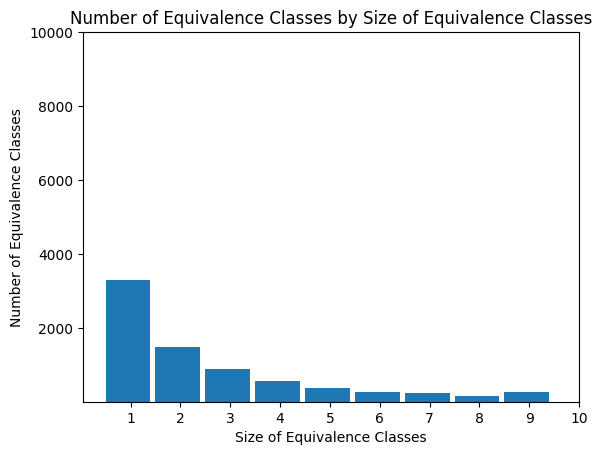

[(1, 8416), (2, 2936), (3, 1472), (4, 875), (5, 645), (6, 420), (7, 359), (8, 264), (9, 386)]


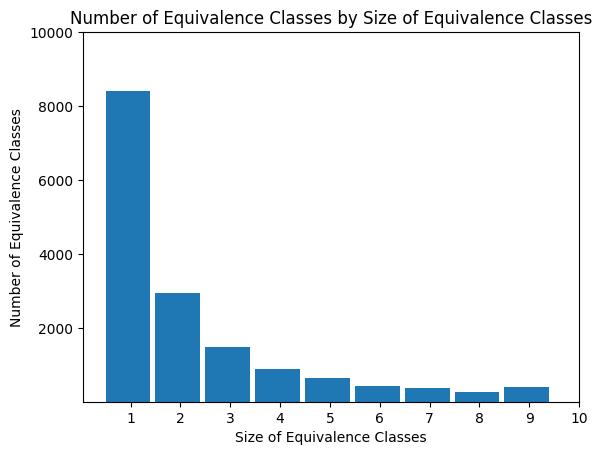

In [ ]:
size_equivalence_classes_small(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes_small(df, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership", "marital_status"])

In [ ]:
df.drop("marital_status", axis=1, inplace=True)

###3.6.2) Record supression - Entropy

In [ ]:
# Returns how many equivalence classes there are in the dataset and their corresponding k-size
# and (for classes with k>1) returns their quasi-identifier combinations
def get_equivalence_class(dataset, data_to_consider):
    grouped_dataset = dataset.groupby(data_to_consider)
    grouped_rows = []
    non_one_equivalent_quasi_ids = []

    for g in grouped_dataset:
        size = len(g[1])
        grouped_rows.append(size)
        # only keep track of equivalence classes (attribute combinations) with k>1
        if (g[0] not in non_one_equivalent_quasi_ids) and (size>1):
            non_one_equivalent_quasi_ids.append((g[0], size))

    count = {}
    for g in grouped_rows:
        if g in count.keys(): count[g] +=1
        else: count[g] = 1

    return count, non_one_equivalent_quasi_ids


# Calculate entropy H of a dataset D:
# H(D) = - sum((C_i/N) * log_s(C_i/N)) for all i, with:
#        - C1,...CK equivalence classes in D,
#        - C_i = number of rows in equivalence class i
#        - N = number of total dataset rows
def calculate_entropy(dataset, attributes):
    H = 0
    N = dataset.shape[0]
    C,_ = get_equivalence_class(dataset, data_to_consider=attributes)

    for (k, num_of_k_equivalen_classes) in C.items():
        H += (num_of_k_equivalen_classes * ((k/N) * math.log2(k/N)))

    return H*(-1)




In [ ]:
def classes(dataset, cols):
    '''Returns the list of sizes of the equivalence classes in the dataset.'''

    groups = dataset.groupby(cols)

    return groups.size().values.tolist()


def nb_to_remove(k,dataset, cols):

    lengths = classes(dataset, cols)
    remove = 0

    for l in lengths:
        if l < k:
            remove += l

    return remove

def to_be_removed(k, dataset, cols):

    result = []

    groups = dataset.groupby(cols)

    for group, idxs in groups:

        if len(idxs) < k:
            result += idxs.index.tolist()

    return result

def remove_rows(k,dataset, cols):

    result = dataset.copy()
    to_remove = to_be_removed(k, dataset, cols)

    result.drop(to_remove, inplace=True)
    return result

In [ ]:
nb_to_remove(4, df, ["region", "age", "gender", "ethnic_group","qualifications", "occupation", "home_ownership"])

8873

k 2: entropy change - 0.9795227026330854, to_remove 3306
k 3: entropy change - 0.9629983144288651, to_remove 6248
k 4: entropy change - 0.9489574979840508, to_remove 8873
k 5: entropy change - 0.937439826880905, to_remove 11093
k 6: entropy change - 0.9277003991410915, to_remove 13013
k 7: entropy change - 0.9197554450098678, to_remove 14609
k 8: entropy change - 0.9113354136970727, to_remove 16324
k 9: entropy change - 0.9050449064870948, to_remove 17620
k 10: entropy change - 0.8984321822658771, to_remove 18997


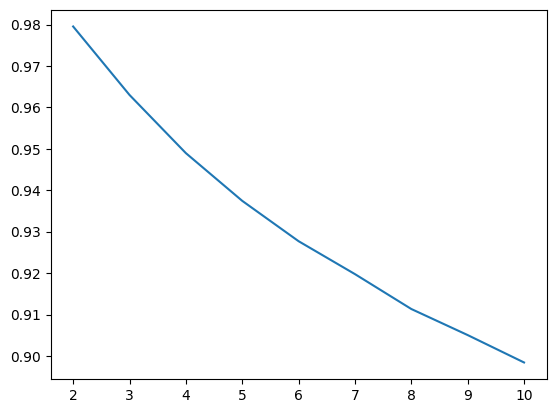

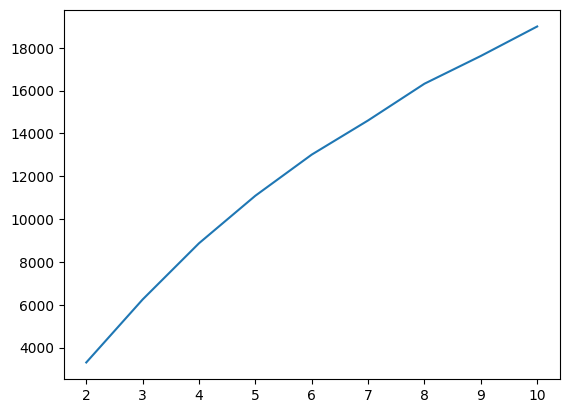

In [ ]:
og_entropy = calculate_entropy(df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', "home_ownership"])
es = []
ns = []
for i in range(2,11):
    df_k = remove_rows(i, df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', "home_ownership"])
    n = nb_to_remove(i, df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', "home_ownership"])
    e = calculate_entropy(df_k, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', "home_ownership"])
    es.append(e/og_entropy)
    ns.append(n)
    print(f"k {i}: entropy change - {e/og_entropy}, to_remove {n}")

plt.plot(list(range(2,11)),es)
plt.show()
plt.plot(list(range(2,11)),ns)

We pick $k=4$ as we only lose around 7% of the entropy (information) while only deleting around 8% of the records

In [ ]:
df = remove_rows(5, df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', "home_ownership"])
df.head()

,gender,ethnic_group,qualifications,occupation,income,home_ownership,distance_to_work_km,age,region
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Female,White,Level 4 (BA+) or above,Service and Care Occupations,29445,1,4.593169,25-40,East Midlands
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Female,White,Level 4 (BA+) or above,Management and Professional Occupations,110432,1,0.000000,25-40,Wales
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Female,White,Level 1-3 (School),Unemployed,4469,0,0.000000,16-25,South East
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Male,White,Level 1-3 (School),Administrative and Support Occupations,26406,0,17.225231,>65,West Midlands
ca7607d30c3d81952cb7cc6903c29c052174ce3090377fb4c6c8ecab48d9333e,Female,White,Apprenticeship,Management and Professional Occupations,78562,1,21.685163,>65,North East


We now generalise distance slightly. Although we have treated this as sensitive attribute, we still generalise this, as even if a record is uniquely identified by an attacker, they would still find it difficult to identify a person and where they work exactly. 0 distances meaning working from home are left as they are so that the data does not lose meaning

In [ ]:
# 5 - Generalise distances into 5km step-ranges
def generalise_distance(dist, max_dist=50, step=5):
    if dist == 0.0:
        return "0"
    prev = 0
    for i in range(0,(max_dist+step),step):
        if (not(prev==i)) and (dist>prev) and (dist <=i):
            dist_range = f"{prev}-{i}"
            return dist_range
        prev = i
    return "n/a"

In [ ]:
df['distance_to_work_km'] = df['distance_to_work_km'].map(generalise_distance)

In [ ]:
df.head()

,gender,ethnic_group,qualifications,occupation,income,home_ownership,distance_to_work_km,age,region
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Female,White,Level 4 (BA+) or above,Service and Care Occupations,29445,1,0-5,25-40,East Midlands
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Female,White,Level 4 (BA+) or above,Management and Professional Occupations,110432,1,0,25-40,Wales
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Female,White,Level 1-3 (School),Unemployed,4469,0,0,16-25,South East
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Male,White,Level 1-3 (School),Administrative and Support Occupations,26406,0,15-20,>65,West Midlands
ca7607d30c3d81952cb7cc6903c29c052174ce3090377fb4c6c8ecab48d9333e,Female,White,Apprenticeship,Management and Professional Occupations,78562,1,20-25,>65,North East


# 4) l-diversity

We can now calculate l-diversity

In [ ]:
def l_diversity(dataset, columns, sensitive_attribute, l):

    groups = dataset.groupby(columns)
    l_diversity_results = {}

    for group, data in groups:
        distinct_values = data[sensitive_attribute].nunique()
        if distinct_values < l:
            return False

    return True

sensitive_attribute = "distance_to_work_km"


In [ ]:
for i in range(2, 6):
    print(f"{i}-diverse: {l_diversity(df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', 'home_ownership'], sensitive_attribute, i)}")


2-diverse: False
3-diverse: False
4-diverse: False
5-diverse: False


In [ ]:

def nb_to_remove_i_diverse(l, dataset, quasi_identifiers, sensitive_attribute):

    remove_count = 0
    groups = dataset.groupby(quasi_identifiers)
    for _, group_data in groups:
        distinct_sensitive_values = group_data[sensitive_attribute].nunique()
        if distinct_sensitive_values < l:
            remove_count += len(group_data)
    return remove_count


quasi_identifiers = ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', "home_ownership"]
sensitive_attribute = 'distance_to_work_km'

for l_val in range(2, 6):
    records_to_remove = nb_to_remove_i_diverse(l_val, df, quasi_identifiers, sensitive_attribute)
    print(f"To achieve {l_val}-diversity: Remove {records_to_remove} records")

To achieve 2-diversity: Remove 32 records
To achieve 3-diversity: Remove 774 records
To achieve 4-diversity: Remove 3622 records
To achieve 5-diversity: Remove 8205 records


To make 3-diverse for distance to work only 774 records need to be removed. Done below.

In [ ]:
def remove_rows_l_diverse(l, dataset, quasi_identifiers, sensitive_attribute):
    result = dataset.copy()
    groups = dataset.groupby(quasi_identifiers)
    indices_to_drop = []
    for _, group_data in groups:
        distinct_sensitive_values = group_data[sensitive_attribute].nunique()
        if distinct_sensitive_values < l:
            indices_to_drop.extend(group_data.index.tolist())
    result.drop(indices_to_drop, inplace=True)
    return result

In [ ]:
df_diversified = remove_rows_l_diverse(3, df, quasi_identifiers, sensitive_attribute)

for i in range(2, 6):
    print(f"{i}-diverse: {l_diversity(df_diversified, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', 'home_ownership'], sensitive_attribute, i)}")

2-diverse: True
3-diverse: True
4-diverse: False
5-diverse: False


In [ ]:
df = df_diversified.copy()

Now we check for the income attribute. We can see this already 3-diverse so nothing needs to be done

In [ ]:
sensitive_attribute = 'income'

for i in range(2, 6):
    print(f"{i}-diverse: {l_diversity(df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', 'home_ownership'], sensitive_attribute, i)}")

2-diverse: True
3-diverse: True
4-diverse: False
5-diverse: False


# 5) t-closeness

In [ ]:
def t_closeness(dataset, columns, sensitive_attribute, t):

    groups = dataset.groupby(columns)

    for _, group_data in groups:
        sensitive_values = group_data[sensitive_attribute].value_counts(normalize=True)
        max_distance = 0
        for prob in sensitive_values:
          distance = abs(prob - 1 / len(sensitive_values))
          max_distance = max(distance,max_distance)

        if max_distance > t:
            return False

    return True

ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [ ]:
sensitive_attribute = "distance_to_work_km"
for t in ts:
    print(f"{t}-close: {t_closeness(df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', 'home_ownership'], sensitive_attribute, t)}")

0.1-close: False
0.2-close: False
0.3-close: False
0.4-close: False
0.5-close: False
0.6-close: True
0.7-close: True
0.8-close: True
0.9-close: True


In [ ]:
sensitive_attribute = "income"
for t in ts:
    print(f"{t}-close: {t_closeness(df, ['region', 'age', 'gender', 'ethnic_group', 'qualifications', 'occupation', 'home_ownership'], sensitive_attribute, t)}")

0.1-close: False
0.2-close: False
0.3-close: False
0.4-close: False
0.5-close: True
0.6-close: True
0.7-close: True
0.8-close: True
0.9-close: True


We can see the dataset is overall 0.6-close. We could make this closer, but this would likely remove patterns in the data and make it less useful.

In [ ]:
df.head()

,gender,ethnic_group,qualifications,occupation,income,home_ownership,distance_to_work_km,age,region
dddeb7aabdab6d09db27b48c507bcefdc75213cac0269e0238c853c44b60c1aa,Female,White,Level 4 (BA+) or above,Service and Care Occupations,29445,1,0-5,25-40,East Midlands
8874d60b3318eced0aa43527b86eea2ec7136f0fe6ae808458b7eb1a82c4ed8f,Female,White,Level 4 (BA+) or above,Management and Professional Occupations,110432,1,0,25-40,Wales
5dcf057bd516ceb1492f1099ec33c8944d62f2d70bdcaeb3f7307810c71926bf,Female,White,Level 1-3 (School),Unemployed,4469,0,0,16-25,South East
17c7096830519a4da644e0bef3abde71a7487ba8eef0104731c45555071a4b15,Male,White,Level 1-3 (School),Administrative and Support Occupations,26406,0,15-20,>65,West Midlands
ca7607d30c3d81952cb7cc6903c29c052174ce3090377fb4c6c8ecab48d9333e,Female,White,Apprenticeship,Management and Professional Occupations,78562,1,20-25,>65,North East
